In [50]:
from py.tap_trial import tap_trial

import numpy as np
import pandas as pd

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from scipy.optimize import minimize

import torch
# from torch.autograd import Variable
# import torch.nn.functional as F

import matplotlib.pyplot as plt

import copy

net_filename = 'SiouxFalls_net.tntp'
true_flows = pd.read_pickle('py/gravity_model/true_flows.pkl')['flow']
true_flows.head()

link
(1,2)    4494.611949
(1,3)    8119.023795
(2,1)    4519.023795
(2,6)    5967.349609
(3,1)    8094.611949
Name: flow, dtype: float64

# Optimizing inputs to a gravity model used to construct and OD matrix

Compared against "ground truth" flows from a reference OD matrix.

## Verifying the cost function

RMSE against reference true flows.

In [2]:
%%time
rmse = tap_trial(netFileName=net_filename, true_flows=true_flows, params=np.ones(276))#np.arange(1,277))
rmse

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 142 ms


4307.949729899668

## Creating a random starting parameter

In [3]:
def random_params(sigma=1, n=276):
    return np.random.lognormal(0, sigma, n)

a_rand_param = random_params(1, 276)
a_rand_param.shape

(276,)

# Trying different optimization algorithms

## Hill climbing algorithm

In [40]:
class HillClimbing:
    
    def __init__(self, n=276, sigma=1, starter_params=None):        
        self.n = n
        self.sigma = 1 # sd of lognormal random components
        self.i = 0 # tracks how many iterations we've run so far
        self.best = starter_params if (starter_params is not None) else random_params(self.sigma, self.n)
        self.minscore = tap_trial(netFileName=net_filename, true_flows=true_flows, params=self.best)
        print(f'0:\t\t {self.minscore}')

        self.steps_progress = []
        self.score_progress = []

    def mutate_params(self, params_to_change):
        new_params = params_to_change.copy()
        index_to_mutate = np.random.randint(self.n)
        new_params[index_to_mutate] = np.random.lognormal(np.log(new_params[index_to_mutate]), self.sigma, 1)
        return new_params
    
    def iterate_solutions(self, max_steps, score_cutoff=0, save_progress=False, show_progress=True):
        
        while self.minscore > score_cutoff:
            if self.i >= max_steps:
                break
            self.i += 1
            
            next_params = self.mutate_params(self.best)
            next_score = tap_trial(netFileName=net_filename, true_flows=true_flows, params=next_params)
            
            if next_score < self.minscore:
                self.best = next_params
                self.minscore = next_score
                if self.i%100==0 and show_progress:
                    print(f'{self.i}:\t\t {self.minscore}')
                if save_progress:
                    self.steps_progress.append(self.i)
                    self.score_progress.append(self.minscore)
        
        if save_progress:
            return self.best, self.minscore, self.steps_progress, self.score_progress
        return self.best, self.minscore

hc = HillClimbing(starter_params=a_rand_param)
hc_best, hc_score, hc_steps_progress, hc_score_progress = hc.iterate_solutions(max_steps=100, save_progress=True)
hc_score

0:		 3644.7685350568636
100:		 2685.9032873357014


2685.9032873357014

## Simulated Annealing

In [41]:
class SimulatedAnnealing(HillClimbing):
    
    def iterate_solutions(self, max_steps, score_cutoff=0, save_progress=False, T=1.0, T_min=0.00001, alpha=0.9, iters_per_temp=100, show_progress=True):
        # T_min is not used

        current_params = self.best
        current_score = self.minscore
        
        while T>T_min:
            for j in range(iters_per_temp):
                if self.i >= max_steps or self.minscore <= score_cutoff:
                    break
                self.i += 1
                
                next_params = self.mutate_params(current_params)
                next_score = tap_trial(netFileName=net_filename, true_flows=true_flows, params=next_params)                
                
                if (next_score < current_score) or (
                        (next_score-current_score<100) and
                        (1/(1+np.exp((next_score-current_score)/T)))):
                    current_params = next_params
                    current_score = next_score

                    if next_score < self.minscore:
                        self.best = next_params
                        self.minscore = next_score
                        if self.i%10==0 and show_progress:
                            print(f'{self.i}:\t\t {self.minscore}')
                        if save_progress:
                            self.steps_progress.append(self.i)
                            self.score_progress.append(self.minscore)
                        # print(next_score)

            T *= alpha

        if save_progress:
            return self.best, self.minscore, self.steps_progress, self.score_progress
        return self.best, self.minscore

sa = SimulatedAnnealing(starter_params=a_rand_param)
sa_best, sa_score, sa_steps_progress, sa_score_progress = sa.iterate_solutions(max_steps=10, save_progress=True)
sa_score


0:		 3644.7685350568636


3541.987744456716

## Scoring

Let's see how they do against each other

0:		 3907.924741341031
0:		 3907.924741341031
0:		 4051.643782739508
0:		 4051.6437827755963
0:		 3353.6430470248406
0:		 3353.6430470248406
0:		 3852.9842864028706
0:		 3852.9842864028706
0:		 3445.7020191643146
0:		 3445.7020191643146


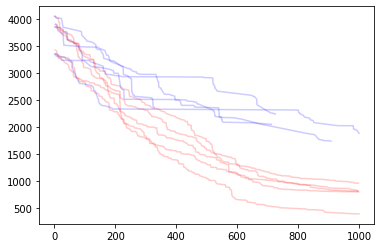

In [43]:
for i in range(5):
    a_new_rand_param = random_params()
    _, _, hcsteps, hcscore = HillClimbing(starter_params=a_new_rand_param).iterate_solutions(max_steps=1000, save_progress=True, show_progress=False)
    _, _, sasteps, sascore = SimulatedAnnealing(starter_params=a_new_rand_param).iterate_solutions(max_steps=1000, save_progress=True, show_progress=False)

    plt.plot(hcsteps, hcscore, c='red', alpha=.2)
    plt.plot(sasteps, sascore, c='blue', alpha=.2)

plt.show()


## Regression

Unlike hill-climbing and simulated annealing, regression techniques will need at least a few data points (honestly, usually it a lot of datapoints) before it can start making decent guesses. The data is used to approximate the function, and then we use an optimizer to minimize the function approximation.

### Warm-starting regression

This function creates $n$ samples out of the dataset in an effort to give our regression techniques enough data to make better guesses about how perturbing the data is likely to minimize the actual cost function.

In [25]:
def perturbation_data_generator(starter_params, n):
    base_rmse = tap_trial(netFileName=net_filename, true_flows=true_flows, params=starter_params)
    d = starter_params.shape[0]
    param_shuffle = np.arange(d)
    np.random.shuffle(param_shuffle)
    if n > d:
        raise ValueError(f'n too large, must be at most {d}')

    inputs = np.atleast_2d(starter_params)
    outputs = base_rmse
    for indices in np.array_split(param_shuffle, n):
        perturbed_params = starter_params.copy()
        perturbed_params[indices] *= 2
        outputs = np.append(outputs, tap_trial(netFileName=net_filename, true_flows=true_flows, params=perturbed_params))
        perturbed_params = np.atleast_2d(perturbed_params)
        inputs = np.append(inputs, perturbed_params, axis=0)
    
    return inputs, outputs

perturbation_data_generator(np.ones(276), 2)

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

## Ridge regression

This is linear regression with a regularization term.

In [47]:
class RidgeRegression:

    def __init__(self, starter_x, starter_y, hidden_layer_nodes=int(276**.5), lr=1e-4, save_data=False):
        self.n = starter_x.shape[1]
        self.best = starter_x[starter_y.argmin(), :]
        self.minscore = starter_y.min()

        self.model = Ridge() #KernelRidge()
        if save_data:
            self.x = starter_x
            self.y = starter_y
        self.model.fit(starter_x, starter_y)

        self.i = 0
        
        self.steps_progress = []
        self.score_progress = []
        self.save_data = save_data

    def __predictor(self, x):
        return self.model.predict(x.reshape(1,-1))

    def iterate_solutions(self, max_steps, score_cutoff=0, save_progress=False):
            
            while self.minscore > score_cutoff:
                if self.i >= max_steps:
                    break
                self.i += 1

                current_params = minimize(self.__predictor, rr.best, method='L-BFGS-B', bounds=np.array([np.ones(self.n)*1e-6, np.ones(self.n)*10]).T, options={'maxfun': 10}).x
                print(current_params)
                next_score = tap_trial(netFileName=net_filename, true_flows=true_flows, params=current_params)
                # print(next_score)

                if self.save_data:
                    self.x = np.append(self.x, current_params, axis=0)
                    self.y = np.append(self.y, next_score)
                    # TODO: batch training

                self.model.fit(current_params.reshape(1, -1), np.array([next_score]))
                
                if next_score < self.minscore:
                    self.best = current_params
                    self.minscore = next_score
                    if self.i%100==0:
                        print(f'{self.i}:\t\t {self.minscore}')
                    if save_progress:
                        self.steps_progress.append(self.i)
                        self.score_progress.append(self.minscore)

            if save_progress:
                return self.best, self.minscore, self.steps_progress, self.score_progress
            return self.best, self.minscore

sx, sy = perturbation_data_generator(np.ones(276), 100)
rr = RidgeRegression(sx, sy)
rr_best, rr_score = rr.iterate_solutions(max_steps=100)
rr_score

. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

4154.949025595368

### Neural regression

Next, let's try using a deep learning regression method. We'll take two approaches:

1. Simply using the derivative of the neural network with respect to its inputs to guess the next best set of inputs.
2. An actor-critic approach, where we pair the regression neural net approximating the RMSE of a set of parameters (the critic) with another one that guesses the next best set of parameters (the actor).

If we set the learning rate to be low, we won't look too far from the prior solutions, probably.

(A best-practice actor-critic model would invole learning a non-deterministic policy with at least a $\mu$ and $\sigma$ for every parameter in order to generate a normal distribution, but that's not exactly feasible here since even the deterministic policy is already overdetermined.)

In [91]:
class NeuralRegression:
    
    def __init__(self, starter_x, starter_y, hidden_layer_nodes=int(276**.5), lr=1e-4, use_policy_nn=False, save_data=False):
        self.n = starter_x.shape[1]
        self.use_policy_nn = use_policy_nn
        self.lr = lr
        self.save_data = save_data

        if self.save_data:
            self.x = starter_x
            self.y = starter_y
        
        self.best = starter_x[starter_y.argmin(), :]
        self.minscore = starter_y.min()

        self.regression_net = torch.nn.Sequential(
            torch.nn.Linear(self.n, hidden_layer_nodes),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_nodes, hidden_layer_nodes),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_nodes, 1)
        ).train()
        self.regression_loss = torch.nn.MSELoss()
        self.regression_optimizer = torch.optim.Adam(self.regression_net.parameters(), lr=lr)

        self.train_regressor(starter_x, starter_y)

        if use_policy_nn:
            self.policy_net = torch.nn.Sequential(
                torch.nn.Linear(self.n, self.n),
                torch.nn.ReLU(),
                torch.nn.Linear(self.n, self.n),
                torch.nn.ReLU(),
                torch.nn.Linear(self.n, self.n),
                torch.nn.ReLU()
            ).train()
            self.policy_optimizer = torch.optim.Adam(self.regression_net.parameters(), lr=lr)

            self.train_policy(starter_x, starter_y)

        self.i = 0
        self.steps_progress = []
        self.score_progress = []
    
    def train_regressor(self, x, y):
        x = torch.tensor(x).float()
        y = torch.tensor(y).float()
        self.regression_optimizer.zero_grad()
        y_hat = self.regression_net(x)
        torch.sqrt(self.regression_loss(y, y_hat)).backward()
        self.regression_optimizer.step()
    
    def train_policy(self, x, y):#, x):#
        x = torch.tensor(x).float()
        y = torch.tensor(y).float()
        self.policy_optimizer.zero_grad()
        # the loss function for the policy is
        # (predicted RMSE of the new params) - (predicted RMSE of the old params)
        # unsure of if the latter term should be the observed RMSE or not instead
        # (predicted RMSE of the new params) - (observed RMSE of the old params)
        # (self.regression_net(self.policy_net(x))-self.regression_net(x)).backward()
        (self.regression_net(self.policy_net(x).clamp(min=1e-6))-y.reshape(-1, 1)).sum().backward()
        self.policy_optimizer.step()

    def iterate_solutions(self, max_steps, score_cutoff=0, save_progress=False):
        
        while self.minscore > score_cutoff:
            if self.i >= max_steps:
                break
            self.i += 1
            
            if self.use_policy_nn: # use policy nn to get the next set of parameters
                current_params = self.policy_net(torch.tensor(self.best).float()).clamp(min=1e-6).data.numpy()
            else: # use gradient of regression nn to get the next set of parameters to try
                # use a copy of the model to backward instead of messing up the gradients of the real thing
                temp_net = copy.deepcopy(self.regression_net)
                temp_opt = torch.optim.Adam(temp_net.parameters(), lr=self.lr)
                temp_opt.load_state_dict(self.regression_optimizer.state_dict())
                current_params = torch.tensor(self.best, requires_grad=True).float()
                temp_opt.zero_grad()
                temp_net(current_params).backward() # this takes the gradient wrt the current input
                temp_opt.step() # this updates the net weights AND the input param based on the gradient
                current_params = current_params.clamp(min=1e-6).data.numpy()

            print(current_params, self.i)
            next_score = tap_trial(netFileName=net_filename, true_flows=true_flows, params=current_params)

            if self.save_data:
                self.x = np.append(self.x, current_params, axis=0)
                self.y = np.append(self.y, next_score)
                # TODO: batch training

            self.train_regressor(current_params, next_score)
            if self.use_policy_nn:
                self.train_policy(current_params, next_score)
            
            if next_score < self.minscore:
                self.best = current_params
                self.minscore = next_score
                if self.i%100==0:
                    print(f'{self.i}:\t\t {self.minscore}')
                if save_progress:
                    self.steps_progress.append(self.i)
                    self.score_progress.append(self.minscore)

        if save_progress:
            return self.best, self.minscore, self.steps_progress, self.score_progress
        return self.best, self.minscore

# use actor
nrac = NeuralRegression(sx, sy, use_policy_nn=True, lr=1e-6)
nrac_best, nrac_score, nrac_steps_progress, nrac_score_progress = nrac.iterate_solutions(max_steps=1_000, save_progress=True)
nrac_score

07 5.16029596e-02 3.35626043e-02
 9.99999997e-07 5.55288754e-02 3.35939750e-02 3.01948264e-02
 9.99999997e-07 9.99999997e-07 9.91121400e-03 4.03256342e-02
 9.99999997e-07 9.99999997e-07 9.99999997e-07 7.13460520e-03
 9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 2.72252876e-02 9.99999997e-07 4.39314879e-02
 9.99999997e-07 9.99999997e-07 1.22562805e-02 9.99999997e-07
 9.99999997e-07 4.66391817e-03 9.99999997e-07 3.27406526e-02
 6.92521110e-02 3.96178178e-02 9.99999997e-07 9.99999997e-07
 2.50220392e-03 9.99999997e-07 4.81574088e-02 2.49204673e-02
 5.57490066e-03 2.82785520e-02 9.99999997e-07 2.57047899e-02
 8.70548189e-04 4.57723364e-02 9.99999997e-07 9.99999997e-07
 9.99999997e-07 3.74781936e-02 9.99999997e-07 9.99999997e-07
 1.91804059e-02 9.99999997e-07 3.69154438e-02 9.99999997e-07
 9.99999997e-07 9.99999997e-07 2.15288810e-03 4.96170670e-02
 1.38851590e-02 9.99999997e-07 1.78226270e-02 5.25587648e-02
 9.99999997e-07 9.99999997e-07 2.95262970e-03 9.9999

KeyboardInterrupt: 

In [92]:
# don't use actor
nr = NeuralRegression(sx, sy, lr=0.1)
nr_best, nr_score, nr_steps_progress, nr_score_progress = nr.iterate_solutions(max_steps=100, save_progress=True)
nr_score

 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 6
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

KeyboardInterrupt: 

## Policy Gradient

This is another deep approach, but instead of trying to approximate the function using regression, we're evaluating the improvement (difference in RMSE) our perturbation makes given the state we moved from (the last set of input parameters).

In [93]:
print('')